# Objective
* 20181225: 
    * Predict stock price in next day using XGBoost
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)
    * Doesn't work well

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 7                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # for the initial model before tuning. default = 100
max_depth = 3                  # for the initial model before tuning. default = 3
learning_rate = 0.1            # for the initial model before tuning. default = 0.1
min_child_weight = 1           # for the initial model before tuning. default = 1
subsample = 1                  # for the initial model before tuning. default = 1
colsample_bytree = 1           # for the initial model before tuning. default = 1
colsample_bylevel = 1          # for the initial model before tuning. default = 1
train_test_split_seed = 111    # 111
model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Load data

In [2]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12


# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [3]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2015-11-25,101.497200,1820300,11,0.410004,0.040001
1,2015-11-27,101.648300,552400,11,0.540001,-0.040001
2,2015-11-30,101.213867,3618100,11,0.739997,0.610001
3,2015-12-01,102.167740,2443600,12,0.839996,-0.590004
4,2015-12-02,101.100533,2937200,12,1.390000,1.049995


Now we use lags up to N number of days to use as features.

In [4]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [5]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df

A Jupyter Widget

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_5,volume_lag_5,adj_close_lag_6,range_hl_lag_6,range_oc_lag_6,volume_lag_6,adj_close_lag_7,range_hl_lag_7,range_oc_lag_7,volume_lag_7
7,2015-12-07,100.628342,3000500,12,1.209999,0.680000,7,101.421646,1.919998,-1.580001,...,0.610001,3618100.0,101.648300,0.540001,-0.040001,552400.0,101.497200,0.410004,0.040001,1820300.0
8,2015-12-08,100.023895,3149600,12,1.130005,0.029998,8,100.628342,1.209999,0.680000,...,-0.590004,2443600.0,101.213867,0.739997,0.610001,3618100.0,101.648300,0.540001,-0.040001,552400.0
9,2015-12-09,99.164467,4179800,12,2.269997,0.550003,9,100.023895,1.130005,0.029998,...,1.049995,2937200.0,102.167740,0.839996,-0.590004,2443600.0,101.213867,0.739997,0.610001,3618100.0
10,2015-12-10,99.457237,3684900,12,1.140000,-0.129998,10,99.164467,2.269997,0.550003,...,1.840004,3345600.0,101.100533,1.390000,1.049995,2937200.0,102.167740,0.839996,-0.590004,2443600.0
11,2015-12-11,97.502281,5100700,12,1.360000,0.930000,11,99.457237,1.140000,-0.129998,...,-1.580001,4520000.0,99.589470,2.420005,1.840004,3345600.0,101.100533,1.390000,1.049995,2937200.0
12,2015-12-14,97.851723,7216200,12,1.540001,-0.250000,12,97.502281,1.360000,0.930000,...,0.680000,3000500.0,101.421646,1.919998,-1.580001,4520000.0,99.589470,2.420005,1.840004,3345600.0
13,2015-12-15,98.900040,2918000,12,0.830001,-0.279999,13,97.851723,1.540001,-0.250000,...,0.029998,3149600.0,100.628342,1.209999,0.680000,3000500.0,101.421646,1.919998,-1.580001,4520000.0
14,2015-12-16,100.335548,5972400,12,1.720001,-0.779999,14,98.900040,0.830001,-0.279999,...,0.550003,4179800.0,100.023895,1.130005,0.029998,3149600.0,100.628342,1.209999,0.680000,3000500.0
15,2015-12-17,98.862267,4939900,12,1.790001,1.760002,15,100.335548,1.720001,-0.779999,...,-0.129998,3684900.0,99.164467,2.269997,0.550003,4179800.0,100.023895,1.130005,0.029998,3149600.0
16,2015-12-18,97.181190,4207700,12,1.459999,1.269996,16,98.862267,1.790001,1.760002,...,0.930000,5100700.0,99.457237,1.140000,-0.129998,3684900.0,99.164467,2.269997,0.550003,4179800.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 7 to 754
Data columns (total 35 columns):
date               748 non-null datetime64[ns]
adj_close          748 non-null float64
volume             748 non-null int64
month              748 non-null int64
range_hl           748 non-null float64
range_oc           748 non-null float64
order_day          748 non-null int64
adj_close_lag_1    748 non-null float64
range_hl_lag_1     748 non-null float64
range_oc_lag_1     748 non-null float64
volume_lag_1       748 non-null float64
adj_close_lag_2    748 non-null float64
range_hl_lag_2     748 non-null float64
range_oc_lag_2     748 non-null float64
volume_lag_2       748 non-null float64
adj_close_lag_3    748 non-null float64
range_hl_lag_3     748 non-null float64
range_oc_lag_3     748 non-null float64
volume_lag_3       748 non-null float64
adj_close_lag_4    748 non-null float64
range_hl_lag_4     748 non-null float64
range_oc_lag_4     748 non-null float64
volume_lag_4  

In [7]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [8]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Split into train, cv and test set

In [9]:
features = [
"adj_close_lag_1",
"range_hl_lag_1",
"range_oc_lag_1",
"volume_lag_1",
"adj_close_lag_2",
"range_hl_lag_2",
"range_oc_lag_2",
"volume_lag_2",
"adj_close_lag_3",
"range_hl_lag_3",
"range_oc_lag_3",
"volume_lag_3",
"adj_close_lag_4",
"range_hl_lag_4",
"range_oc_lag_4",
"volume_lag_4",
"adj_close_lag_5",
"range_hl_lag_5",
"range_oc_lag_5",
"volume_lag_5",
"adj_close_lag_6",
"range_hl_lag_6",
"range_oc_lag_6",
"volume_lag_6",
"adj_close_lag_7",
"range_hl_lag_7",
"range_oc_lag_7",
"volume_lag_7"
]

target = "adj_close"

# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train+1:num_train+num_cv]
train_cv = df[:num_train+num_cv+1]
test = df[num_train+num_cv+1:]

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (450, 28)
y_train.shape = (450,)
X_cv.shape = (148, 28)
y_cv.shape = (148,)
X_train_cv.shape = (600, 28)
y_train_cv.shape = (600,)
X_sample.shape = (148, 28)
y_sample.shape = (148,)


# EDA

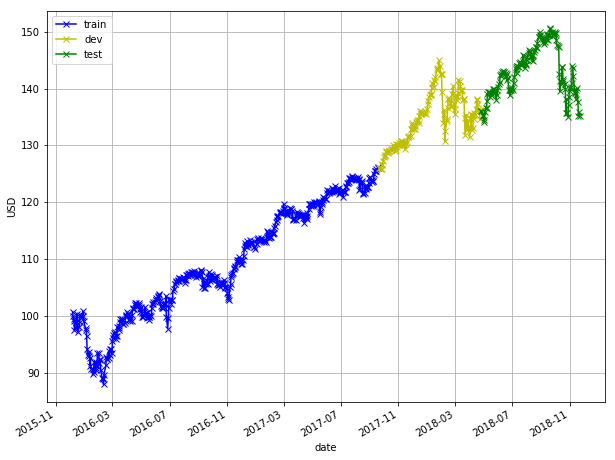

In [10]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Train the model using XGBoost

In [11]:
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
       silent=True, subsample=1)

# Predict on train set

In [12]:
# Do prediction on train set
est = model.predict(X_train)

# Calculate RMSE
math.sqrt(mean_squared_error(y_train, est))

0.4218812527374346

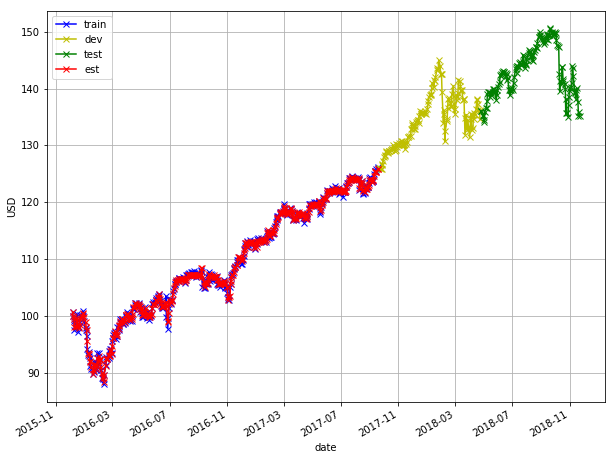

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict on dev set

In [14]:
# Do prediction on test set
est = model.predict(X_cv)

# Calculate RMSE
math.sqrt(mean_squared_error(y_cv, est))

10.355092522389082

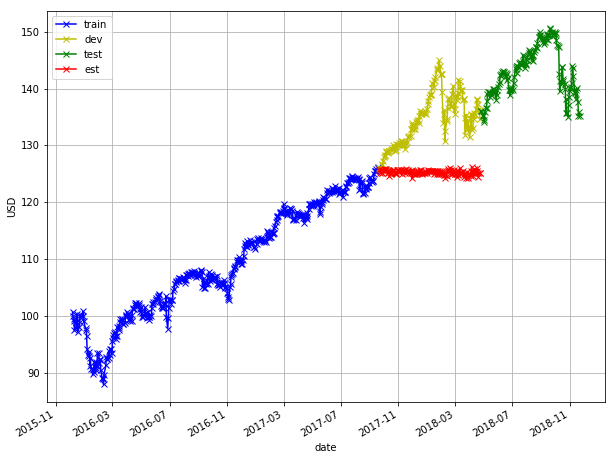

In [15]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Findings
* Doesn't work well
* Likely because the model was trained on prices below 125 and so when it saw prices above 125 for the dev set, it could not generalize well.